In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder

import json
import random
from datetime import datetime
import time
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import re

print(tf.__version__)

2.1.0-rc0


In [2]:
SEED = 2019
tf.random.set_seed(SEED)

classes = ['0',             # 0
           '1',             # 1
           '10',            # 2
           '2',             # 3
           '3',             # 4
           '4',             # 5
           '5',             # 6
           '6',             # 7
           '7',             # 8
           '8',             # 9
           '9',             # 10
           'no',            # 11
           'yes']           # 12

PATH = "/kaggle/input/ann-and-dl-vqa/dataset_vqa"

num_labels = 13
batch_size = 64

MAX_SEQUENCE_LENGTH = 32
IMG_HEIGHT, IMG_WIDTH = 320, 480
scale_ratio = 0.75
IMG_HEIGHT, IMG_WIDTH = int(IMG_HEIGHT*scale_ratio), int(IMG_WIDTH * scale_ratio)


## Load data from json files

In [3]:
with open(os.path.join(PATH, 'train_data.json'), 'r') as f:
    train_data = json.load(f)
f.close()

with open(os.path.join(PATH, 'test_data.json'), 'r') as f:
    test_data = json.load(f)
f.close()

train_data = train_data['questions']
test_data = test_data['questions']

train_dataset_size = len(train_data) # number of questions --> 259492


### format of data

In [4]:
train_data[1:3]

[{'answer': '0',
  'image_filename': 'CLEVR_train_000000.png',
  'question': 'How many gray matte things are on the right side of the small rubber cube behind the large brown thing left of the cyan thing?'},
 {'answer': 'yes',
  'image_filename': 'CLEVR_train_000000.png',
  'question': 'Are there any other things that have the same size as the brown shiny sphere?'}]

# Data Generator

## Tokenizer
The tokenizer translate question made of words into vectors of numbers.
by default the tokenizer get rids of punctuation. This has been avoided by splitting words base only on spaces. 

Answers are preprocessed so as to divide punctuation from words by at least a space.
The number of terms that the tokenizer can be encoded, has to be fixed before start using it. For such a reason questions are extracted and fed into the tokenizer so it can determine all the parametrs that are necessary for its usage. 

In [5]:
def separate_punctuation_from_words(string):
    to_tokenize = '.,:;!?'
    string = re.sub(r'(['+to_tokenize+'])', r' \1 ', string)
    # we had to substitute a unknown term
    return re.sub(r'matte', r'opaque', string)

for i,q in enumerate(train_data):
    train_data[i]['question'] = separate_punctuation_from_words(train_data[i]['question'].lower())

for i,q in enumerate(test_data):
    test_data[i]['question'] = separate_punctuation_from_words(test_data[i]['question'].lower())
    
    


In [6]:
!ls /kaggle/input/20-newsgroup-original/20_newsgroup

20_newsgroup		  misc.forsale	      sci.med
alt.atheism		  rec.autos	      sci.space
comp.graphics		  rec.motorcycles     soc.religion.christian
comp.os.ms-windows.misc   rec.sport.baseball  talk.politics.guns
comp.sys.ibm.pc.hardware  rec.sport.hockey    talk.politics.mideast
comp.sys.mac.hardware	  sci.crypt	      talk.politics.misc
comp.windows.x		  sci.electronics     talk.religion.misc


In [7]:
import sys

BASE_DIR = '/kaggle/input/'
GLOVE_DIR = os.path.join(BASE_DIR, 'glove6b')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20-newsgroup-original', '20_newsgroup', '20_newsgroup')
MAX_SEQUENCE_LENGTH = 64
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100


# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))

# finally, vectorize the text samples into a 2D integer tensor
t = Tokenizer(num_words=MAX_NUM_WORDS)
t.fit_on_texts(texts)
sequences = t.texts_to_sequences(texts)

word_index = t.word_index
print('Found %s unique tokens.' % len(word_index))

print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
from tensorflow.keras.layers import Embedding
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer= tf.keras.initializers.Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)



Indexing word vectors.
Found 400000 word vectors.
Processing text dataset
Found 19997 texts.
Found 174074 unique tokens.
Preparing embedding matrix.


In [8]:
#example of tokenizer usage 
t.texts_to_sequences(['the tiny metallic cylinder ?'])


[[1, 4512, 13240, 5013]]

In [9]:
# check that all questions are made with terms that 
# the embedding is able to use.
texts    = [el['question']for el in train_data ]
texts.extend(el['question']for el in test_data )

max_words = max([len(line.split()) for line in texts])
words = set( np.concatenate([line.split() for line in texts]))
print('Found (',len(words),') words in our questions:',words)
print('Questions are at most ',max_words,' word long ')
      
for w in words:
    if (w in '.,:;!?'):
        continue
    assert not ( w not in word_index or word_index[w] is 0 )

Found ( 72 ) words in our questions: {'opaque', 'green', 'thing', 'many', 'size', 'any', 'metallic', 'tiny', 'to', 'number', 'another', 'on', 'what', 'made', 'same', 'that', 'is', 'either', 'brown', 'balls', 'there', 'objects', 'how', 'sphere', 'side', 'anything', 'metal', 'blocks', 'block', 'cylinders', 'a', 'both', 'object', 'yellow', 'in', 'front', 'big', 'cubes', 'else', 'rubber', 'spheres', 'gray', 'as', 'cylinder', '?', 'right', 'visible', 'or', 'are', 'large', 'the', 'of', 'small', 'have', 'color', 'things', 'shape', 'red', 'shiny', 'it', 'ball', 'purple', ';', 'has', 'behind', 'blue', 'left', 'cube', 'and', 'cyan', 'other', 'material'}
Questions are at most  43  word long 


### MyDataset
this class hide the steps that led to the dataset creation and the split between validation and training set.
This class can be supplied with :
- a predicate that filters the element in json. It is used to acquire a subset of questions related to a certain answer
- a field that indicates what part of each object contained in json variable has to be taken
- a function 'funct' that is executed of the field extracted before building the dataset

In [37]:

class myDataset(tf.data.Dataset):
   
    def __new__(self, json, field, output_shapes, output_types, validation_split=0.0,
                seed=None, subset='training', funct = None, filt=None , verbose=False, randomize=True):
        
        #1. set seed if available
        if(seed is not None):
            tf.random.set_seed(SEED)
            np.random.seed(SEED)
        #2. divide questions in two sets randomly.
        #print(os.listdir(basepath))
           
        self.subset = json
        #if present use a filter
        if filt is not None:
            if(verbose):
                 print('executed: ',filt)
            self.subset = list(filter(filt, self.subset))
        
        if(randomize):
            np.random.shuffle(self.subset)

        split_indx = round( validation_split * len(self.subset) )
        #3. take the part corresponding to to either the validation
        # or the training subset
        if subset == 'validation':
            self.number_of_items = split_indx
            self.subset = self.subset[:split_indx]
            
            
        else :
            self.number_of_items =len(self.subset)- split_indx
            self.subset = self.subset[split_indx:]
            
        
        if(verbose):
            #print number of items carried
            print( self.number_of_items, 'items ingested')
            #print field
            print( 'taking field ', field)
        
        
            
        #extract field from json
        self.subset = list(map(lambda el: el[field], self.subset))
        
        #define an high order function that will be passed 
        # to tf.data.Dataset.from_generator to obtain the dataset.
        def get_generator(funct, randomize):
            def generator(subset):
                
                res = subset
                
                if randomize:
                    np.random.shuffle(res)
                
                if funct is not None:
                    if(verbose):
                        print('executed:',funct)
                    res = map(funct, res)

                res = map(tf.convert_to_tensor, res)

                for el in iter(res):
                    yield el
                
            return generator
        
        generator = get_generator(funct, randomize)
        
        return self.number_of_items, tf.data.Dataset.from_generator(
            generator,
            output_types=output_types,
            output_shapes=output_shapes,
            args = (self.subset,)
        )
    
    def number_of_items(self):
        return self.number_of_items


### Create a evenly distributed dataset
To create a dataset that is not unbalanced w.r.t. the answers, in the initial steps we create different dataset for each answer. ~~Those are later recombined using [tf.data.experimental.sample_from_datasets](https://www.tensorflow.org/api_docs/python/tf/data/experimental/sample_from_datasets?version=stable).~~
Since with sample_from_dataset still answers are a bit umbalanced 

I thought it is better to create batch by extracting in a circular fashion from every dataset referring to a specific answer.To accomplish this [choose_from_dataset](https://www.tensorflow.org/api_docs/python/tf/data/experimental/choose_from_datasets)
was used.
result: 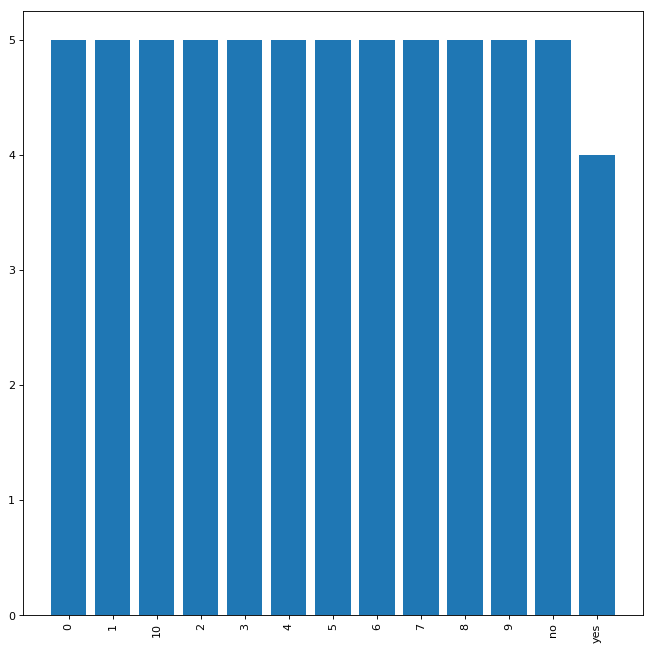

Each dataset for each answer is built by separated dataset. Why?
Each field of the answer is picked up separately so as to perform a specific preprocessing fucntion to the field we are considering.
Then Dataset of each field are recombined via [tf.data.Dataset.zip](https://www.tensorflow.org/api_docs/python/tf/data/Dataset?version=stable#zip).

In [40]:
#this function returns a dataset for a specific answer
def get_dataset_for_answer(data, ans=None,skip_ans=False, subpath='train', validation_split=0.2, 
                           subset='training', randomize=True):
    #define a filter so as to pick up only a specific type of answer
    def get_answer_selector(ans):
        def answer_selector(el):
            return el['answer']==ans
        return answer_selector
    
    if ans is not None:
        answer_selector = get_answer_selector(ans)
    else:
        answer_selector = None
        
    #dataset containing questions
    #high order function to encode question
    def get_encoder_question(t):
        def question_encoder(text):
            #use tokenizer to encode the sequences
            sequences = t.texts_to_sequences([text.decode("utf-8")])
            sequences = sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
            return sequences[0]
        return question_encoder
        
    question_encoder = get_encoder_question(t)
    #obtain the dataset containing questions
    n_elements,dataset_questions = myDataset(data,'question', 
                             output_shapes     = (MAX_SEQUENCE_LENGTH),
                             output_types      = tf.int32,
                             subset            = subset,
                             funct             = question_encoder, 
                             filt              = answer_selector,
                             validation_split  = validation_split, 
                             seed              = SEED,
                             randomize         = randomize)
    
    #dataset containing answers
    #high order function that encodes the answers with a custom format. 
    #This allows to tackle the problem both as a regression and a classification problem.
    
    def get_answer_encoder(classes):
        def answer_encoder(answer):
            answer = answer.decode('utf-8')
            res = np.zeros(4)

            if answer == 'yes':
                res[0] = 1
            elif answer == 'no':
                res[1] = 1
            else :
                res[2] = 1
                res[3] = int(answer)/10

            return res
        return answer_encoder
    answer_encoder = get_answer_encoder(classes)
    #obtain the dataset containing answers
    if not skip_ans:
        _,dataset_answer = myDataset(data,'answer', 
                                 output_shapes    = (4),
                                 output_types     = tf.float32,
                                 subset           = subset,
                                 funct            = answer_encoder, 
                                 filt             = answer_selector,
                                 validation_split = validation_split, 
                                 seed             = SEED,
                                 randomize         = randomize)

    #dataset containing images
    #high order function that load image from the disk and impose values between [0-1].
    def get_image_loader(basepath):
        def image_loader(path):
            path = os.path.join(basepath ,path.decode("utf-8"))

            img = Image.open(path)
            img = img.resize((IMG_WIDTH,IMG_HEIGHT ))
            img = np.array(img)[:,:,:3]

            img = img * 1.0 / 255

            return img
        return image_loader
    image_loader = get_image_loader(os.path.join(PATH, subpath))
    #obtain the dataset containing images
    _,dataset_images = myDataset(data,'image_filename', 
                             output_shapes   = (IMG_HEIGHT, IMG_WIDTH,3),
                             output_types    = tf.float32,
                             subset          = subset,
                             filt            = answer_selector,
                             funct           = image_loader, 
                             validation_split= validation_split, 
                             seed            = SEED,
                             randomize         = randomize)
    
    # ZIP datasets for a given answer
    dataset_res = tf.data.Dataset.zip((dataset_images,dataset_questions))
    if not skip_ans:
        dataset_res = tf.data.Dataset.zip((dataset_res,dataset_answer))
    number_steps = n_elements / batch_size 
    
    print('Number of batches',number_steps)
    #return the dataset for a given answer
    
    return dataset_res, n_elements

#obtain a training/validation dataset for each answer
training_datasets = []
validation_datasets = []
frequency_answers = []
tot_answers = 0
for ans in classes:
    print('obtaining dataset for',ans)
    dataset_ans, _ = get_dataset_for_answer(train_data,ans, subset='training')
    dataset_ans_val, n_elements = get_dataset_for_answer(train_data, ans, subset='validation')
    
    frequency_answers.append(n_elements)
    tot_answers += n_elements
    
    training_datasets.append(dataset_ans.shuffle(10).repeat())
    validation_datasets.append(dataset_ans_val)


#combine the datasets together 
choice_dataset1 = tf.data.Dataset.range(len(classes)).repeat()
frequency_dataset = np.array(frequency_answers) / tot_answers

train_dataset = tf.data.experimental.choose_from_datasets(training_datasets, choice_dataset1).batch( batch_size,drop_remainder=True )
valid_dataset = tf.data.experimental.sample_from_datasets(validation_datasets,frequency_dataset).batch( batch_size,drop_remainder=True )


obtaining dataset for 0
Number of batches 608.21875
Number of batches 152.0625
obtaining dataset for 1
Number of batches 723.84375
Number of batches 180.953125
obtaining dataset for 10
Number of batches 0.296875
Number of batches 0.078125
obtaining dataset for 2
Number of batches 373.1875
Number of batches 93.296875
obtaining dataset for 3
Number of batches 190.703125
Number of batches 47.671875
obtaining dataset for 4
Number of batches 92.71875
Number of batches 23.1875
obtaining dataset for 5
Number of batches 45.1875
Number of batches 11.296875
obtaining dataset for 6
Number of batches 20.78125
Number of batches 5.1875
obtaining dataset for 7
Number of batches 8.09375
Number of batches 2.015625
obtaining dataset for 8
Number of batches 3.234375
Number of batches 0.8125
obtaining dataset for 9
Number of batches 1.3125
Number of batches 0.328125
obtaining dataset for no
Number of batches 588.984375
Number of batches 147.25
obtaining dataset for yes
Number of batches 587.09375
Number o

TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [12]:
it = iter(train_dataset)


[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0   80  125 4821
  193   19  436  912 5795   22 1153 5795]
question ['how many rubber things are small blue cylinders or green cylinders']
image
answer (yes[binary], no[binary] , count[binary], number_regression[0-10]) tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)


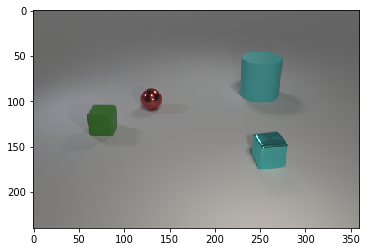

In [13]:
#example on how to obtain a data sample from the dataset

batch = next(it)
target_batch = batch[1]
input_batch  = batch[0]
sequences = input_batch[1]
images    = input_batch[0]
print(sequences[0].numpy())
print('question', t.sequences_to_texts([sequences[0].numpy()]))
print('image')
plt.figure()
plt.imshow(images[0])

print('answer (yes[binary], no[binary] , count[binary], number_regression[0-10])', target_batch[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  19  39  55 436 193]
question ['are there any small things']
image
answer (yes[binary], no[binary] , count[binary], number_regression[0-10]) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


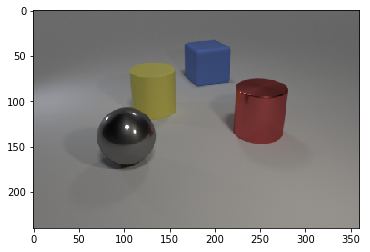

In [14]:
#example on how to obtain a data sample from the dataset

batch = next(it)
target_batch = batch[1]
input_batch  = batch[0]
sequences = input_batch[1]
images    = input_batch[0]
print(sequences[0].numpy())
print('question', t.sequences_to_texts([sequences[0].numpy()]))
print('image')
plt.figure()
plt.imshow(images[0])

print('answer (yes[binary], no[binary] , count[binary], number_regression[0-10])', target_batch[0])

In [15]:
#example of dot product for later usage in Luong attention
a = tf.constant([[[1,0],[0,1], [1,1]]])
b = tf.constant([[[1,0]]])
a = tf.cast(a, tf.float32)
b = tf.cast(b, tf.float32)
print(a.shape, b.shape)

c = tf.keras.layers.dot([a,b], axes=2)
print(c.shape, c)

weights =tf.keras.layers.Softmax(axis=1)(c)
print(weights.shape, weights)
import math
print(math.exp(c[0,0,0])/(math.exp(c[0,0,0])+ math.exp(c[0,1,0])+ math.exp(c[0,2,0]) )) #OK


(1, 3, 2) (1, 1, 2)
(1, 3, 1) tf.Tensor(
[[[1.]
  [0.]
  [1.]]], shape=(1, 3, 1), dtype=float32)
(1, 3, 1) tf.Tensor(
[[[0.42231882]
  [0.15536241]
  [0.42231882]]], shape=(1, 3, 1), dtype=float32)
0.4223187982515182


# Model architecture

In [16]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, LSTM, GRU, Embedding, Dense, Dropout, Concatenate
from tensorflow.keras.layers import BatchNormalization, Bidirectional
from tensorflow.keras.models import Model, Sequential

def get_Vision_Model():
    # Define CNN for Image Input
    vision_model = Sequential()
    vision_model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    vision_model.add(Conv2D(8, (3, 3), activation='relu'))
    vision_model.add(MaxPooling2D((2, 2)))
    vision_model.add(BatchNormalization())
    vision_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
    vision_model.add(Conv2D(16, (3, 3), activation='relu'))
    vision_model.add(MaxPooling2D((2, 2)))
    vision_model.add(BatchNormalization())
    vision_model.add(Conv2D(24, (3, 3), activation='relu', padding='same'))
    vision_model.add(Conv2D(24, (3, 3), activation='relu'))
    vision_model.add(MaxPooling2D((2, 2)))
    vision_model.add(BatchNormalization())
    vision_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    vision_model.add(Conv2D(32, (3, 3), activation='relu'))
    vision_model.add(MaxPooling2D((2, 2)))
    return vision_model

def get_Vision_Model():
    vision_model = tf.keras.applications.vgg19.VGG19( include_top=False,weights='imagenet')
    vision_model.trainable = False
    return vision_model
    

image_input = Input(shape=(IMG_HEIGHT, IMG_WIDTH,3), name='img_input')
vision_output = get_Vision_Model()(image_input)
vision_output = Conv2D(32, (1, 1), activation='relu')(vision_output)

# Define RNN for language input (batch_size, max_sequence_length)
question_input        = Input(shape=(MAX_SEQUENCE_LENGTH,), name='text_input', dtype='int32')
embedded_question     = embedding_layer(question_input)
# embedding output shape = (batch_size, max_sequence, embedding_space_size )
# embedding output[batch_indx, time_step, specific_embedding_space_dimension]
embedded_question_dim = embedded_question.shape[2]

encoded_question      = GRU(4*embedded_question_dim, return_sequences=True)(embedded_question)
cell_output_history, cell_output_final  = GRU(4*embedded_question_dim, return_sequences=True, return_state=True)(encoded_question)

class LuongAttention(tf.keras.layers.Layer):
  def __init__(self):
    super(LuongAttention, self).__init__()

  def call(self, query, values):
    # inputs:
    # -    query comes from LSTM current output
    #      query shape == (batch_size, hidden size)
    # -    values comes from LSTM previous outputs 
    #      values shape == (batch_size, time_steps, hidden size)
    
    # we cannot ensure that these vector comes from the same 
    # LSTM cell, but at least w can ensure that they are compatible
    query = tf.expand_dims(query, axis=1)
    assert ( query.shape[2] == values.shape[2])
    
    # we are doing this to perform mat multiplication , which is 
    # another way to say that every vector inside values has to 
    # be scalarly multiplied with the query vector.
    # note: to avoid discrepncies due to the norm of the vectors
    #       we used normalization which means divide by the product of 
    #       the two norm. We obtain the cosine of the two vectors.
    scores = tf.keras.layers.dot([values, query], axes=2, normalize=True)
    #score shape == (batch_size, sequence_steps, 1)
    
    
    attention_weights = tf.nn.softmax(scores, axis=1)
    #attention_weights shape == (batch_size, sequence steps, 1)
    
    
    weigthed_values = attention_weights * values
    res             = tf.reduce_sum(weigthed_values, axis=1)

    return attention_weights ,  res


attention, encoded_question = LuongAttention()(cell_output_final, cell_output_history)
flatten_vision_output = Flatten()(vision_output)
# Combine CNN and RNN to create the final model
merged = tf.keras.layers.concatenate([encoded_question, flatten_vision_output])
dense = Dense(512, activation='relu')(merged)
dropout = Dropout(0.3)(dense)

output_classification = Dense(3, activation='softmax')(dropout)#3 = [yes, no, regression]
output_regression     = Dense(1, activation='sigmoid')(dropout)#1 output 0-1 to mimic 0-10 answer
output = Concatenate()([output_classification, output_regression])
vqa_model = Model(inputs=[image_input, question_input], outputs=output)

80142336/80134624 [==============================] - 2s 0us/step


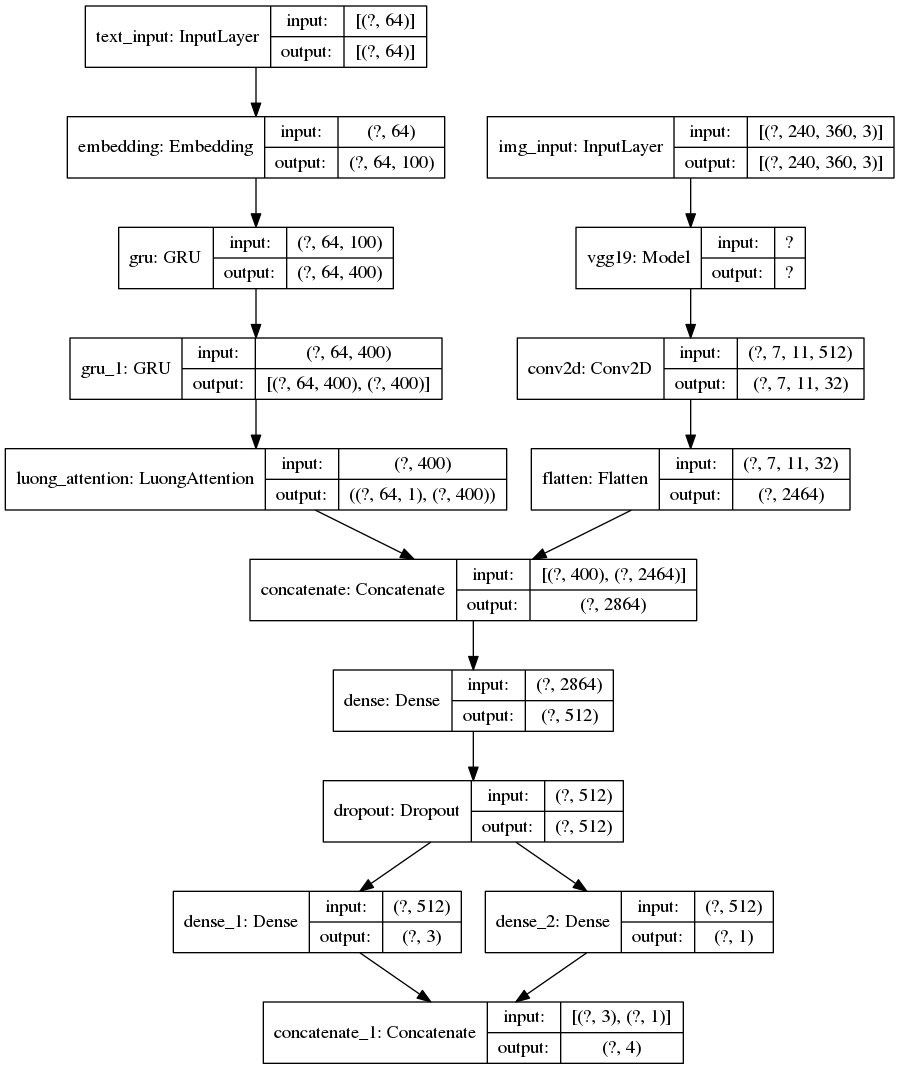

In [17]:
plot_model(vqa_model, show_shapes=True)

In [18]:
vqa_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 100)      2000000     text_input[0][0]                 
__________________________________________________________________________________________________
img_input (InputLayer)          [(None, 240, 360, 3) 0                                            
__________________________________________________________________________________________________
gru (GRU)                       (None, 64, 400)      602400      embedding[0][0]                  
______________________________________________________________________________________________

## Custom loss
since has beem decided to tackle the problem as both a classification and regression problem a custom loss was required.

The output of the NN has been encoded as follows:
- binary 1hot encoding 'yes'
- binary 1hot encoding 'no'
- binary 1hot encoding 'regression_problem'
- regression output ranging from 0 to 1 , representing numbers between 0 to 10.

The loss function is a combination of categorical cross entropy and MSE. The MSE term is considered only when the expected answer refer to a counting problem, that is when the third one hot is active. 
inspiration from [FasterRCnn](https://arxiv.org/abs/1506.01497)

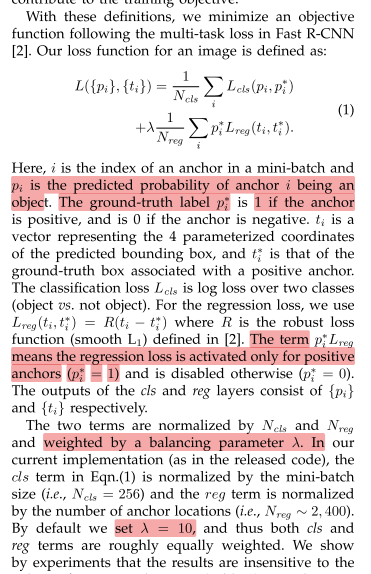

In [19]:
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.losses import categorical_crossentropy
# Function used to extract categorical and regression term when y related
# to a single sample
def custom_encod2cat_reg(y):
    #ytrue/ypred is made of 4 numbers
    # - binary 1hot encoding 'yes'
    # - binary 1hot encoding 'no'
    # - binary 1hot encoding 'regression_problem'
    # - regression output ranging from 0 to 1 , but representing 0 to 10.
    
    cat, regr = tf.split(y, [3, 1], axis=0)
   
    return cat, 10*regr

# Function used to extract categorical and regression term when y related
# to a batch
def custom_encods2cat_reg(y):
    #ytrue/ypred is made of 4 numbers
    # - binary 1hot encoding 'yes'
    # - binary 1hot encoding 'no'
    # - binary 1hot encoding 'regression_problem'
    # - regression output ranging from 0 to 1 , but representing 0 to 10.
    
    cat, regr = tf.split(y, [3, 1], axis=1)
   
    return cat, 10*regr

#custom loss
def loss(y_true, y_pred):
    #move from custom encoding to separated component (categorical and regression components)
    cat_y_true, regr_y_true = custom_encods2cat_reg(y_true)
    cat_y_pred, regr_y_pred = custom_encods2cat_reg(y_pred)
    # from t_true categorical extract the 1-hot that express whether the answer
    # was a regression or not for later usage
    
    _, cat_y_true_reg = tf.split(cat_y_true, [2, 1], axis=1)
    w = 1
    # sum the loss of two components categorical and regression
    # regression is only considered when the answer was truly related to regression (counting)
    # inspiration from FasterR-CNN with the loss related to bounding box regression and "objectness" measure
    reg_loss = cat_y_true_reg * w *mean_squared_error(regr_y_true, regr_y_pred)
    
    #reg_loss = cat_y_true_reg *w *tf.keras.losses.mean_absolute_error(regr_y_true, regr_y_pred)
    
    loss = categorical_crossentropy(cat_y_true, cat_y_pred) + reg_loss
    
    return loss

In [20]:
#example of usage
print (loss([[0,0,1,0.1]], [[0,0,1,0.8]]))

print( loss([[0,0,1,0.1]], [[0,0.9,0,0.8]]))

tf.Tensor([[49.]], shape=(1, 1), dtype=float32)
tf.Tensor([[65.118095]], shape=(1, 1), dtype=float32)


## Custom metric
Since the encoding differs from the one used to evaluate the work on kaggle we have to
return to the original encoding before supply the tensors to categorical_accuracy function.


In [21]:
from tensorflow.keras.metrics import categorical_accuracy
#Function used to move from custom encoding back to the original encoding used in 
# the Kaggle competition. Used in case y relates to a single sample
def custom_encod2cat(y):
    # extract categorical and regression terms out of the custom encoding
    cat_y, regr_y = custom_encod2cat_reg(y)
    #separate in from the categorical part of the output the one hot related to 
    # - indicates yes 
    # - indicates no
    # - indicates a regression
    cat_yes, cat_no ,cat_regr= tf.split(cat_y, [1,1,1], axis=0)
    
    # move from regression output to one hot between 11 classes
    regr_one_hot = tf.reshape(tf.one_hot( tf.cast(tf.math.round(regr_y), tf.uint8), 11), [-1])
    # multiply with one hot that indicates whether this was a regression problem or not
    # so as to eliminate regression one hot in case cat_regr is low
    regr_one_hot = cat_regr * regr_one_hot
    
    #rearrange one hots to reflect the output expected by the kaggle competition    
    reg_01, regr_29 ,regr_10= tf.split(regr_one_hot, [2,8,1], axis=0)
    categorical = tf.concat([reg_01, regr_10, regr_29, cat_no, cat_yes ], axis=0)
   
    return categorical

#Function used to move from custom encoding back to the original encoding used in 
# the Kaggle competition. Used in case y relates to a batch
def custom_encods2cat(ys):
    
    return tf.map_fn(custom_encod2cat, ys)
    
    

#custom metric "adapter"
def metric(y_true, y_pred):
    
    y_true = custom_encods2cat(y_true)
    y_pred = custom_encods2cat(y_pred)
    
    return categorical_accuracy(y_true, y_pred)

In [22]:
#test of usage
for p in range(1,11):
    for num in range(11):
        assert np.argmax(custom_encod2cat([p/10 -0.1,p/10-0.1,p/10,num/10])) == classes.index(str(num)) 


In [23]:
# Optimization parameters

lr = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

# Validation metrics
metrics = [metric]

# Compile Model (change the name for each model)
vqa_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [26]:
history = vqa_model.fit(
              train_dataset.prefetch(tf.data.experimental.AUTOTUNE),
              steps_per_epoch = 100,
              epochs=40,
              validation_freq = 1,
              validation_data=valid_dataset.prefetch(tf.data.experimental.AUTOTUNE),
              validation_steps = 20
          )

Train for 100 steps, validate for 20 steps
Epoch 1/40
100/100 [==============================] - 108s 1s/step - loss: 0.9948 - metric: 0.4609 - val_loss: 2.2167 - val_metric: 0.3039
Epoch 2/40
100/100 [==============================] - 103s 1s/step - loss: 1.0020 - metric: 0.4563 - val_loss: 1.9887 - val_metric: 0.3164
Epoch 3/40
100/100 [==============================] - 103s 1s/step - loss: 1.0462 - metric: 0.4550 - val_loss: 2.2325 - val_metric: 0.3164
Epoch 4/40
100/100 [==============================] - 102s 1s/step - loss: 1.0524 - metric: 0.4533 - val_loss: 2.1105 - val_metric: 0.3109
Epoch 5/40
100/100 [==============================] - 98s 977ms/step - loss: 1.0004 - metric: 0.4630 - val_loss: 1.8993 - val_metric: 0.3297
Epoch 6/40
100/100 [==============================] - 95s 952ms/step - loss: 0.9977 - metric: 0.4766 - val_loss: 1.9754 - val_metric: 0.3273
Epoch 7/40
100/100 [==============================] - 96s 956ms/step - loss: 1.0018 - metric: 0.4487 - val_loss: 2.0984

KeyboardInterrupt: 

In [ ]:
Train for 100 steps, validate for 20 steps
Epoch 1/40
100/100 [==============================] - 157s 2s/step - loss: 27.3903 - metric: 0.0772 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 2/40
100/100 [==============================] - 133s 1s/step - loss: 27.5371 - metric: 0.0769 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 3/40
100/100 [==============================] - 135s 1s/step - loss: 27.5491 - metric: 0.0769 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 4/40
100/100 [==============================] - 133s 1s/step - loss: 27.5368 - metric: 0.0770 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 5/40
100/100 [==============================] - 124s 1s/step - loss: 27.5328 - metric: 0.0769 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 6/40
100/100 [==============================] - 119s 1s/step - loss: 27.5560 - metric: 0.0769 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 7/40
100/100 [==============================] - 118s 1s/step - loss: 27.5215 - metric: 0.0770 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 8/40
100/100 [==============================] - 120s 1s/step - loss: 27.5427 - metric: 0.0769 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 9/40
100/100 [==============================] - 120s 1s/step - loss: 27.5487 - metric: 0.0769 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 10/40
100/100 [==============================] - 119s 1s/step - loss: 27.5320 - metric: 0.0770 - val_loss: 27.5186 - val_metric: 0.0773
Epoch 11/40
100/100 [==============================] - 91s 912ms/step - loss: 27.5407 - metric: 0.0769


In [ ]:
vqa_model.save_weights('weights.h5')

In [35]:
vqa_model.evaluate(valid_dataset)

    452/Unknown - 388s 859ms/step - loss: 1.2256 - metric: 0.3934

KeyboardInterrupt: 

In [ ]:
with lst+Attention+2feature extracted by cnn(vgg19) and attention 
Train for 400 steps, validate for 30 steps
Epoch 1/40
400/400 [==============================] - 456s 1s/step - loss: 3.7495 - metric: 0.2298 - val_loss: 1.9585 - val_metric: 0.2859
Epoch 2/40
400/400 [==============================] - 434s 1s/step - loss: 2.7119 - metric: 0.2842 - val_loss: 6.2830 - val_metric: 0.1203
Epoch 3/40
400/400 [==============================] - 432s 1s/step - loss: 6.3343 - metric: 0.1217 - val_loss: 6.0117 - val_metric: 0.1245
Epoch 4/40
400/400 [==============================] - 457s 1s/step - loss: 3.5880 - metric: 0.1938 - val_loss: 2.7448 - val_metric: 0.2302
Epoch 5/40
400/400 [==============================] - 453s 1s/step - loss: 1.8468 - metric: 0.3146 - val_loss: 1.8292 - val_metric: 0.3375
Epoch 6/40
400/400 [==============================] - 441s 1s/step - loss: 1.5372 - metric: 0.3557 - val_loss: 1.6639 - val_metric: 0.3271
Epoch 7/40
400/400 [==============================] - 439s 1s/step - loss: 1.4580 - metric: 0.3636 - val_loss: 1.7018 - val_metric: 0.3208
Epoch 8/40
400/400 [==============================] - 436s 1s/step - loss: 1.3808 - metric: 0.3802 - val_loss: 1.4699 - val_metric: 0.3594
Epoch 9/40
400/400 [==============================] - 439s 1s/step - loss: 1.3452 - metric: 0.3828 - val_loss: 1.6619 - val_metric: 0.3448
Epoch 10/40
400/400 [==============================] - 439s 1s/step - loss: 1.3126 - metric: 0.3847 - val_loss: 1.5265 - val_metric: 0.3630
Epoch 11/40
400/400 [==============================] - 439s 1s/step - loss: 1.3005 - metric: 0.3909 - val_loss: 1.6439 - val_metric: 0.3500
Epoch 12/40
276/400 [===================>..........] - ETA: 2:05 - loss: 1.2393 - metric: 0.4021







# Evaluate results

In [ ]:
# Code snippet used in a first time to evaluate
# models' capabilities. In particular was used to try spotting correlations
# between errors both on the training and on the validation dataset.

def computeConfusion(dataset, max_num ):
    confusion_matrix = [[ 0 for i in range(0,len(classes))] for i in range(0,len(classes))];

    it = iter(dataset)
    i = 0;
    while( i < max_num):
        batch = next(it)
        sample = batch[0]
        labels = batch[1]
        for j,l in enumerate(labels):

            if(i > max_num):
                break;
    
            res = vqa_model.predict((tf.expand_dims(sample[0][j], axis=0), tf.expand_dims(sample[1][j], axis=0)) )

            expected = np.argmax(custom_encod2cat(l))

            predicted = np.argmax(custom_encods2cat(res)[0]);
            
            confusion_matrix[expected][predicted] +=1
            i+=1

    plotConfusionMatrix(confusion_matrix);
      
def plotConfusionMatrix(conf):
    plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
    im = plt.imshow(conf)
    plt.yticks(range(0,len(classes)), labels=classes);
    plt.xticks(range(0,len(classes)), labels=classes, rotation='vertical' );
    plt.ylabel("expected");
    plt.xlabel("predicted");
    plt.gca().invert_yaxis()
    plt.colorbar();

    for y in range(len(conf)):
        for x in range(len(conf[y])):
            plt.text(x, y , '{:.0f}'.format(conf[y][x]),
                  color='w',horizontalalignment='center',
                  verticalalignment='center')


computeConfusion(train_dataset, 400);
computeConfusion(valid_dataset, 400);

In [ ]:
# The following code snippet was used to have an idea on 
# dataset distribution across the classes.
def plotDatasetDistribution(dataset, max_num ):
    classes_count = [0 for i in range(len(classes))]

    it = iter(dataset)
    i = 0;
    while( i < max_num):
        batch = next(it)
        labels = batch[1]
        for l in labels:
            if(i > max_num):
                break
            expected = np.argmax(custom_encod2cat(l))
            classes_count[expected]+=1
            i+=1
    #print(classes_count)
    plt.figure( figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k');
    plt.bar(range(len(classes)), classes_count )
    plt.xticks( ticks=range(len(classes)) ,labels=classes, rotation='vertical' )
    plt.show()

plotDatasetDistribution(train_dataset, 400)
plotDatasetDistribution(valid_dataset, 400)

In [ ]:
import gc
del train_dataset_cached
gc.collect()

# Collecting predictions

In [27]:
#we can obtain a dataset in the same way we have done for the training_testset
dataset_test = get_dataset_for_answer(test_data,ans=None, skip_ans=True, subpath='test',
                                      subset='training', validation_split=0.0, randomize=False)
#Keras conventions require that inputs to model predict are
# tuples (input, None)
# in our specific case
# tuples ( (img_input, text_input) , None)
dataset_test = tf.data.Dataset.zip((dataset_test, )).batch(batch_size)

3000 items ingested
taking field  question
3000 items ingested
taking field  image_filename
Number of batches 46.875


In [28]:
test_data[:4]

[{'question_id': 0,
  'image_filename': 'CLEVR_val_009641.png',
  'question': 'are there any tiny green things made of the same material as the small brown sphere ? '},
 {'question_id': 1,
  'image_filename': 'CLEVR_val_010849.png',
  'question': 'are there any purple metal things of the same size as the green shiny object ? '},
 {'question_id': 2,
  'image_filename': 'CLEVR_val_004213.png',
  'question': 'is there a big thing of the same color as the big metal ball ? '},
 {'question_id': 3,
  'image_filename': 'CLEVR_val_012597.png',
  'question': 'there is a big metallic thing to the right of the blue rubber object ;  are there any small cyan rubber blocks that are to the right of it ? '}]

(64, 240, 360, 3) (64, 64)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0  19  39  55 436 193]
question ['are there any small things']
image
answer (yes[binary], no[binary] , count[binary], number_regression[0-10]) tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


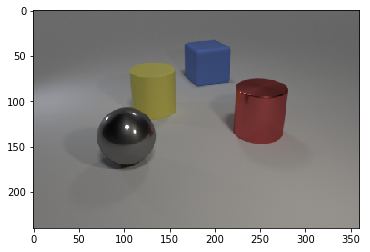

In [29]:
#check that the conventions are respected
it = iter(dataset_test)

input_batch  = batch[0]

sequences = input_batch[1]
images    = input_batch[0]

print(images.shape, sequences.shape)
#check elements order is respected
print(sequences[0].numpy())
print('question', t.sequences_to_texts([sequences[0].numpy()]))
print('image')
plt.figure()
plt.imshow(images[0])

print('answer (yes[binary], no[binary] , count[binary], number_regression[0-10])', target_batch[0])

In [30]:
#predict from dataset
answers = vqa_model.predict(dataset_test)
#answers is a vector of outputs 

In [31]:
print('answers',answers[:4])
# a fast check that all answers have been all collected
assert(len(answers) == len (test_data))
cat_anwers = custom_encods2cat(answers)

print('categorized',cat_anwers[:4])
num_answers = tf.argmax(cat_anwers,axis=1)
print(num_answers[:4])
print(len(num_answers), len(test_data))
assert(len(num_answers) == len (test_data))

answers [[5.4960656e-01 4.5037049e-01 2.2948181e-05 2.4585724e-03]
 [5.2587998e-01 4.7411519e-01 4.8568008e-06 1.0829270e-03]
 [5.7350320e-01 4.2649579e-01 1.0491761e-06 5.5405498e-04]
 [4.4939518e-01 5.5060315e-01 1.6217715e-06 6.9442391e-04]]
categorized tf.Tensor(
[[2.2948181e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 4.5037049e-01 5.4960656e-01]
 [4.8568008e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 4.7411519e-01 5.2587998e-01]
 [1.0491761e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 4.2649579e-01 5.7350320e-01]
 [1.6217715e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 5.506

In [32]:
results = {}
for i,el in enumerate(num_answers):
    results[i] = el.numpy()

In [33]:
res_bin = np.zeros(len(classes))
for k in results:
    res_bin[results[k]] +=1

In [ ]:
plt.plot(res_bin)

%46 accuracy
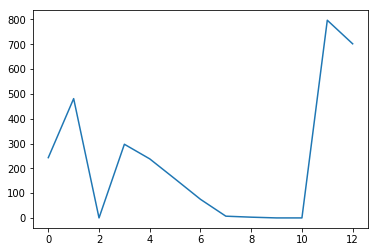

In [ ]:
results

In [34]:
import os
from datetime import datetime

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(str(key) + ',' + str(value) + '\n')

create_csv(results)